In [1]:
!pip install torch torchvision
!pip install tensorflow_hub

import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# Configuration
DATA_DIR = "/content/drive/MyDrive/images/Preprocessed_split3"
IMG_SIZE = 224
BATCH = 16
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
SEED = 50
NUM_CLASSES = 12

HEAD_LR = 1e-4
BASE_LR = 1e-5
WEIGHT_DECAY = 0.05
EPOCHS_HEAD = 5
EPOCHS_FT = 30
PATIENCE = 5

torch.manual_seed(SEED)

# Data Augmentation & Normalization
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset Loading
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
total_size = len(full_dataset)

train_size = int(total_size * TRAIN_SPLIT)
val_size = int(total_size * VAL_SPLIT)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Set val/test transforms (no CutMix)
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=8, pin_memory=True)

# Load Places365 pretrained model
resnet18_places365 = models.resnet18(num_classes=365)
checkpoint = torch.hub.load_state_dict_from_url(
    'http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar',
    progress=True
)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

resnet18_places365.load_state_dict(new_state_dict)

resnet18_places365.fc = nn.Linear(resnet18_places365.fc.in_features, NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18_places365.to(device)


Downloading: "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar" to /root/.cache/torch/hub/checkpoints/resnet18_places365.pth.tar
100%|██████████| 43.4M/43.4M [00:04<00:00, 11.2MB/s]


In [ ]:
# loss definition

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce(inputs, targets)
        pt = torch.exp(logpt)
        if self.alpha is not None:
            if self.alpha.type() != inputs.dtype:
                self.alpha = self.alpha.type_as(inputs)
            at = self.alpha.gather(0, targets)
            logpt = logpt * at
        loss = -((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

criterion = FocalLoss(gamma=2.0, alpha=None)

# CutMix helper
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Training function
def train_one_epoch(model, optimizer, criterion, train_loader, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        r = np.random.rand()
        if r < 0.5:
            lam = np.random.beta(1.0, 1.0)
            rand_index = torch.randperm(images.size()[0]).to(device)
            target_a = labels
            target_b = labels[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]

            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        if r >= 0.5:
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        else:
            correct += (lam * (preds == target_a).sum().item() + (1 - lam) * (preds == target_b).sum().item())
            total += labels.size(0)

        loop.set_postfix(loss=running_loss / total if total > 0 else 0,
                         accuracy=correct / total if total > 0 else 0)
    return running_loss / total, correct / total

def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total


In [ ]:
scaler = torch.cuda.amp.GradScaler()

# Stage 1: Train only the fc layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.fc.parameters(), lr=HEAD_LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, min_lr=1e-6)

writer = SummaryWriter(log_dir=f"runs/geo_tf_{int(time.time())}")

best_val_acc = 0.0
epochs_no_improve = 0

print("=== Stage 1: Training FC layer only ===")
for epoch in range(EPOCHS_HEAD):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device, scaler)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS_HEAD} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_geo_pytorch.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1} of Stage 1")
            break

# Stage 2: Unfreeze layer4 and continue fine-tuning
print("\n=== Stage 2: Unfreeze layer4 and train ===")

for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': HEAD_LR},
    {'params': model.layer4.parameters(), 'lr': BASE_LR},
], weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, min_lr=1e-6)
epochs_no_improve = 0

for epoch in range(EPOCHS_FT):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device, scaler)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS_FT} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, EPOCHS_HEAD + epoch)
    writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, EPOCHS_HEAD + epoch)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_geo_pytorch.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1} of Stage 2")
            break

# Test evaluation
model.load_state_dict(torch.load("best_geo_pytorch.pth"))
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_acc = correct_test / total_test
print(f"\nTest Accuracy: {test_acc:.4f}")

writer.close()

# Save Model, Class Names, and Configuration
import pickle
import os

SAVE_DIR = "/content/drive/MyDrive/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), SAVE_DIR + "best_model_weights.pth")

# Save the model class names for future interpretation
class_names = full_dataset.classes
with open(SAVE_DIR + "class_names.pkl", 'wb') as f:
    pickle.dump(class_names, f)

# Save training configuration
config = {
    "IMG_SIZE": IMG_SIZE,
    "BATCH": BATCH,
    "NUM_CLASSES": NUM_CLASSES,
    "transform_mean": [0.485, 0.456, 0.406],
    "transform_std": [0.229, 0.224, 0.225],
    "model_arch": "resnet18_places365",
    "checkpoint_url": 'http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar'
}
with open(SAVE_DIR + "training_config.pkl", 'wb') as f:
    pickle.dump(config, f)

print(f"Model, class names, and config saved to: {SAVE_DIR}")


<ipython-input-4-6e142ca9a959>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


=== Stage 1: Training FC layer only ===


  0%|          | 0/348 [00:00<?, ?it/s]<ipython-input-3-298bd14049bb>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  0%|          | 1/348 [00:28<2:45:02, 28.54s/it, accuracy=0.0744, loss=2.14]<ipython-input-3-298bd14049bb>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 348/348 [17:02<00:00,  2.94s/it, accuracy=0.181, loss=1.93]
<ipython-input-3-298bd14049bb>:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 | Train Loss: 1.9266 Acc: 0.1814 | Val Loss: 1.6930 Acc: 0.3392


100%|██████████| 348/348 [07:00<00:00,  1.21s/it, accuracy=0.299, loss=1.71]


Epoch 2/5 | Train Loss: 1.7097 Acc: 0.2989 | Val Loss: 1.4838 Acc: 0.4249


100%|██████████| 348/348 [07:02<00:00,  1.21s/it, accuracy=0.342, loss=1.58]


Epoch 3/5 | Train Loss: 1.5770 Acc: 0.3424 | Val Loss: 1.3487 Acc: 0.4601


100%|██████████| 348/348 [07:04<00:00,  1.22s/it, accuracy=0.383, loss=1.5]


Epoch 4/5 | Train Loss: 1.4951 Acc: 0.3832 | Val Loss: 1.2377 Acc: 0.4895


100%|██████████| 348/348 [07:01<00:00,  1.21s/it, accuracy=0.388, loss=1.44]


Epoch 5/5 | Train Loss: 1.4388 Acc: 0.3877 | Val Loss: 1.1888 Acc: 0.5063

=== Stage 2: Unfreeze layer4 and train ===


100%|██████████| 348/348 [07:06<00:00,  1.23s/it, accuracy=0.441, loss=1.26]


Epoch 1/30 | Train Loss: 1.2633 Acc: 0.4409 | Val Loss: 0.8574 Acc: 0.5886


100%|██████████| 348/348 [07:03<00:00,  1.22s/it, accuracy=0.506, loss=1.09]


Epoch 2/30 | Train Loss: 1.0903 Acc: 0.5059 | Val Loss: 0.7286 Acc: 0.6348


100%|██████████| 348/348 [07:03<00:00,  1.22s/it, accuracy=0.561, loss=0.948]


Epoch 3/30 | Train Loss: 0.9484 Acc: 0.5610 | Val Loss: 0.6160 Acc: 0.6784


100%|██████████| 348/348 [07:01<00:00,  1.21s/it, accuracy=0.609, loss=0.84]


Epoch 4/30 | Train Loss: 0.8401 Acc: 0.6088 | Val Loss: 0.5537 Acc: 0.6969


100%|██████████| 348/348 [07:01<00:00,  1.21s/it, accuracy=0.651, loss=0.753]


Epoch 5/30 | Train Loss: 0.7535 Acc: 0.6505 | Val Loss: 0.5024 Acc: 0.7221


100%|██████████| 348/348 [07:10<00:00,  1.24s/it, accuracy=0.659, loss=0.737]


Epoch 6/30 | Train Loss: 0.7375 Acc: 0.6591 | Val Loss: 0.4895 Acc: 0.7187


100%|██████████| 348/348 [07:03<00:00,  1.22s/it, accuracy=0.688, loss=0.688]


Epoch 7/30 | Train Loss: 0.6883 Acc: 0.6877 | Val Loss: 0.4538 Acc: 0.7431


100%|██████████| 348/348 [07:03<00:00,  1.22s/it, accuracy=0.698, loss=0.667]


Epoch 8/30 | Train Loss: 0.6672 Acc: 0.6979 | Val Loss: 0.4241 Acc: 0.7599


100%|██████████| 348/348 [07:04<00:00,  1.22s/it, accuracy=0.722, loss=0.619]


Epoch 9/30 | Train Loss: 0.6190 Acc: 0.7217 | Val Loss: 0.4217 Acc: 0.7515


100%|██████████| 348/348 [07:07<00:00,  1.23s/it, accuracy=0.715, loss=0.636]


Epoch 10/30 | Train Loss: 0.6362 Acc: 0.7153 | Val Loss: 0.3944 Acc: 0.7674


100%|██████████| 348/348 [07:08<00:00,  1.23s/it, accuracy=0.75, loss=0.57]


Epoch 11/30 | Train Loss: 0.5700 Acc: 0.7497 | Val Loss: 0.3850 Acc: 0.7817


100%|██████████| 348/348 [07:10<00:00,  1.24s/it, accuracy=0.763, loss=0.55]


Epoch 12/30 | Train Loss: 0.5503 Acc: 0.7628 | Val Loss: 0.3896 Acc: 0.7834


100%|██████████| 348/348 [07:04<00:00,  1.22s/it, accuracy=0.769, loss=0.553]


Epoch 13/30 | Train Loss: 0.5531 Acc: 0.7694 | Val Loss: 0.3677 Acc: 0.7901


100%|██████████| 348/348 [07:11<00:00,  1.24s/it, accuracy=0.768, loss=0.55]


Epoch 14/30 | Train Loss: 0.5495 Acc: 0.7677 | Val Loss: 0.3647 Acc: 0.7825


100%|██████████| 348/348 [07:00<00:00,  1.21s/it, accuracy=0.796, loss=0.474]


Epoch 15/30 | Train Loss: 0.4745 Acc: 0.7962 | Val Loss: 0.3689 Acc: 0.7825


100%|██████████| 348/348 [07:04<00:00,  1.22s/it, accuracy=0.809, loss=0.444]


Epoch 16/30 | Train Loss: 0.4437 Acc: 0.8092 | Val Loss: 0.3634 Acc: 0.7943


100%|██████████| 348/348 [07:08<00:00,  1.23s/it, accuracy=0.799, loss=0.482]


Epoch 17/30 | Train Loss: 0.4821 Acc: 0.7990 | Val Loss: 0.3521 Acc: 0.7993


100%|██████████| 348/348 [07:04<00:00,  1.22s/it, accuracy=0.795, loss=0.478]


Epoch 18/30 | Train Loss: 0.4785 Acc: 0.7954 | Val Loss: 0.3531 Acc: 0.7968


100%|██████████| 348/348 [07:05<00:00,  1.22s/it, accuracy=0.814, loss=0.443]


Epoch 19/30 | Train Loss: 0.4425 Acc: 0.8143 | Val Loss: 0.3560 Acc: 0.7960


100%|██████████| 348/348 [07:02<00:00,  1.21s/it, accuracy=0.835, loss=0.411]


Epoch 20/30 | Train Loss: 0.4110 Acc: 0.8354 | Val Loss: 0.3572 Acc: 0.7918


100%|██████████| 348/348 [07:10<00:00,  1.24s/it, accuracy=0.807, loss=0.454]


Epoch 21/30 | Train Loss: 0.4542 Acc: 0.8073 | Val Loss: 0.3455 Acc: 0.7985


100%|██████████| 348/348 [07:06<00:00,  1.23s/it, accuracy=0.83, loss=0.414]


Epoch 22/30 | Train Loss: 0.4135 Acc: 0.8301 | Val Loss: 0.3612 Acc: 0.7935
Early stopping triggered at epoch 22 of Stage 2


<ipython-input-4-6e142ca9a959>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Test Accuracy: 0.8087
✅ Model, class names, and config saved to: /content/drive/MyDrive/


In [2]:
# model loading after saving
import pickle

# Configuration
SAVE_DIR = "/content/drive/MyDrive/"
DATA_DIR = SAVE_DIR + "images/Preprocessed_split3"  # if relative to Drive
IMG_SIZE = 224
BATCH = 16
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
SEED = 50
NUM_CLASSES = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset & Dataloaders
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
total_size = len(full_dataset)
train_size = int(total_size * TRAIN_SPLIT)
val_size = int(total_size * VAL_SPLIT)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=8, pin_memory=True)

# Load Trained Model
model = models.resnet18(num_classes=NUM_CLASSES)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(SAVE_DIR + "best_model_weights.pth"))
model.to(device)
model.eval()

# Load Class Names
with open(SAVE_DIR + "class_names.pkl", 'rb') as f:
    class_names = pickle.load(f)


In [ ]:
# summary stats

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

   argentina       0.79      0.81      0.80        70
     austria       0.72      0.70      0.71       128
      canada       0.86      0.89      0.87       128
       chile       0.87      0.86      0.87       110
      france       0.63      0.50      0.56       100
     iceland       0.98      0.90      0.94        51
       italy       0.62      0.63      0.62       110
       japan       0.86      0.86      0.86       110
 new_zealand       0.97      1.00      0.98        85
      norway       0.89      0.98      0.93        87
        peru       0.78      0.86      0.82        71
 switzerland       0.81      0.83      0.82       142

    accuracy                           0.81      1192
   macro avg       0.82      0.82      0.82      1192
weighted avg       0.81      0.81      0.81      1192



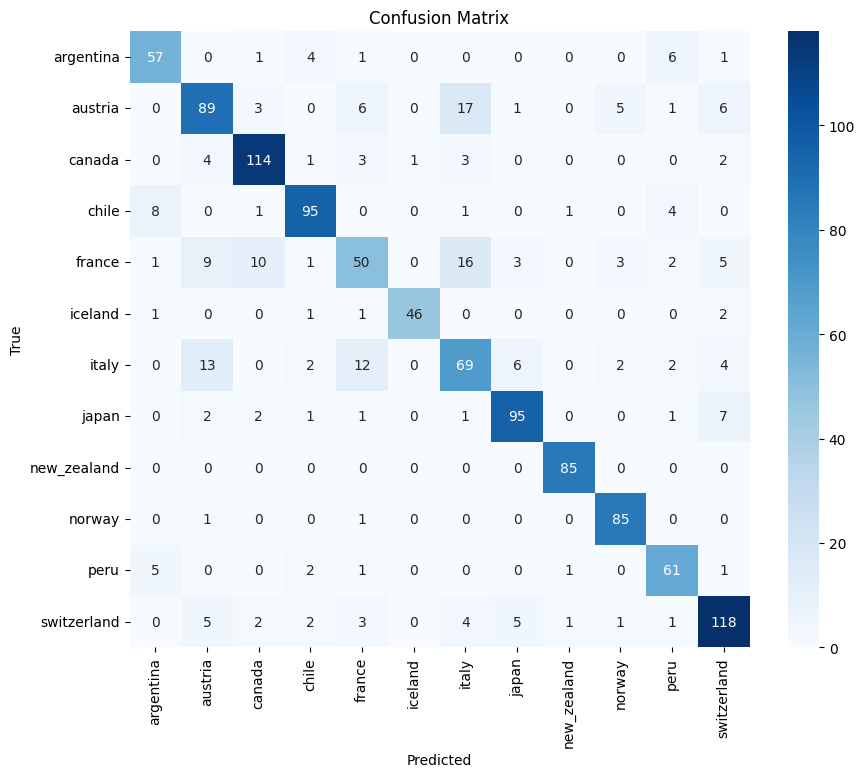

In [ ]:
# Confusion matrix visualized

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1813: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'torch.fx.proxy.Proxy'>
  warnings.warn("For backward hooks to be called,"
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1813: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'torch.fx.proxy.Proxy'>
  warnings.warn("For backward hooks to be called,"


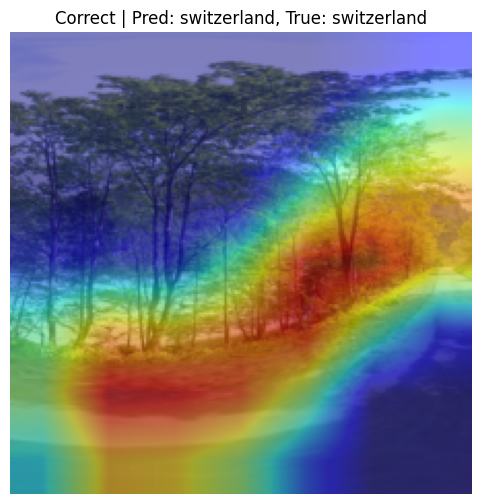

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1813: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'torch.fx.proxy.Proxy'>
  warnings.warn("For backward hooks to be called,"
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1813: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'torch.fx.proxy.Proxy'>
  warnings.warn("For backward hooks to be called,"


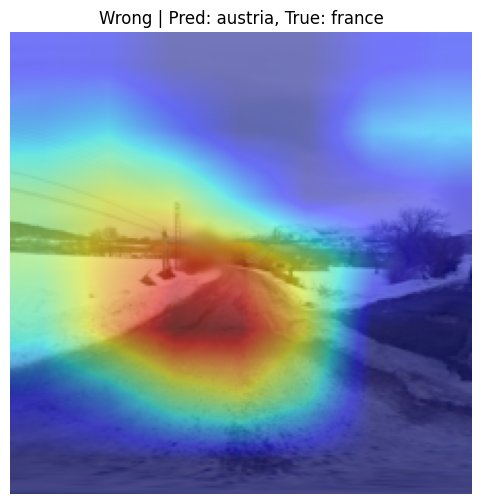

In [ ]:
# GradCAM
def compute_gradcam(model, input_tensor, target_class, target_layer='layer4'):
    # Prepare feature extractor
    return_nodes = {target_layer: 'feat_map'}
    feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
    gradients = []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hook
    handle = model._modules[target_layer][-1].register_full_backward_hook(save_gradient)

    model.zero_grad()
    input_batch = input_tensor.unsqueeze(0).to(device)
    output = model(input_batch)
    pred_class = output.argmax(dim=1).item()

    output[0, target_class].backward()

    activations = feature_extractor(input_batch)['feat_map'].squeeze(0)
    grads = gradients[0].squeeze(0)

    weights = grads.mean(dim=(1, 2))
    cam = (weights[:, None, None] * activations).sum(0)
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

    handle.remove()
    return cam, pred_class

def plot_gradcam_overlay(input_tensor, cam, pred_class, true_class, title_prefix=""):
    img = input_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"{title_prefix}Pred: {class_names[pred_class]}, True: {class_names[true_class]}")
    plt.axis("off")
    plt.show()

# Find and show examples
for i, (input_tensor, true_class) in enumerate(test_dataset):
    pred_class = all_preds[i]
    if pred_class == true_class:
        cam, _ = compute_gradcam(model, input_tensor, pred_class)
        plot_gradcam_overlay(input_tensor, cam, pred_class, true_class, title_prefix="Correct | ")
        break

for i, (input_tensor, true_class) in enumerate(test_dataset):
    pred_class = all_preds[i]
    if pred_class != true_class:
        cam, _ = compute_gradcam(model, input_tensor, pred_class)
        plot_gradcam_overlay(input_tensor, cam, pred_class, true_class, title_prefix="Wrong | ")
        break


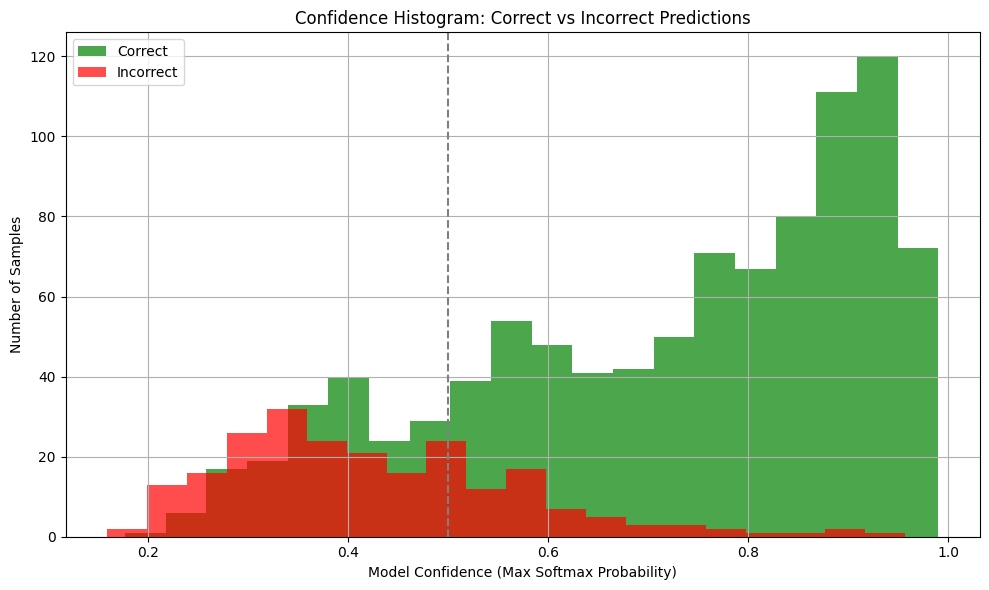

In [ ]:
# Confidence histogram
confidences = []
correctness = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        correctness.extend((preds == labels).cpu().numpy())

# Split confidences by correctness
confidences = np.array(confidences)
correctness = np.array(correctness)

plt.figure(figsize=(10, 6))
plt.hist(confidences[correctness == 1], bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(confidences[correctness == 0], bins=20, alpha=0.7, label='Incorrect', color='red')
plt.axvline(x=0.5, color='gray', linestyle='--')
plt.xlabel("Model Confidence (Max Softmax Probability)")
plt.ylabel("Number of Samples")
plt.title("Confidence Histogram: Correct vs Incorrect Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# top-3

top1_wrong_total = 0
top3_correct_within_wrong = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        top3_preds = torch.topk(probs, k=3, dim=1).indices
        top1_preds = top3_preds[:, 0]

        for i in range(labels.size(0)):
            if top1_preds[i] != labels[i]:
                top1_wrong_total += 1
                if labels[i] in top3_preds[i]:
                    top3_correct_within_wrong += 1

print(f"Number of incorrect top-1 predictions: {top1_wrong_total}")
print(f"Among them, correct label was in top-3: {top3_correct_within_wrong}")
print(f"Recovery Rate: {top3_correct_within_wrong/top1_wrong_total:.2%}")


❌ Number of incorrect top-1 predictions: 228
✅ Among them, correct label was in top-3: 178
📊 Recovery Rate: 78.07%
